# Multi-armed Bandit Recommender System

## Env

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import Recommenders
import Bandits

## Dataset

In [2]:
events = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\events.csv')
categories = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\category_tree.csv')
item_properties_part1 = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\item_properties_part1.csv')
item_properties_part2 = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\item_properties_part2.csv')

In [3]:
# Concatenate item_properties_part1 and item_properties_part2
properties = pd.concat([item_properties_part1, item_properties_part2], ignore_index=True)

## Data Exploring, Cleaning and Feature Engineering

### Events

#### itemid

In [4]:
# Filter only events with itemid in properties
events = events[events['itemid'].isin(properties['itemid'])]

### Recommended items and user picking

#### Items

In [5]:
# Store the most representative purchased items
rec_items = events[events['event'] == 'transaction']['itemid']\
    .value_counts(normalize=True)\
        .sort_values(ascending=False)\
            .cumsum()\
                .loc[lambda x: x <= 0.8].index.tolist()

There might be some items that were purchased but not viewed or added to cart. These could be taken out of the recommended items list as we want optimize the user interaction in all ways with the purchased items

In [6]:
# Check if all items that were purchased were also viewed or added to cart
purchased_notviewed_notadded = events[((events['event'] == 'transaction') & 
       (events['itemid']
        .isin(events[events['event'] == 'view']['itemid'])==False)) | 
       ((events['event'] == 'transaction') & 
       (events['itemid']
        .isin(events[events['event'] == 'addtocart']['itemid'])==False))]['itemid'].unique()


In [7]:
# Remove the items that were purchased but not viewed or added to cart from the rec_items list
rec_items = [itm for itm in rec_items if itm not in purchased_notviewed_notadded]

### Properties

In [68]:
properties = properties[properties['itemid'].isin(events['itemid'].unique())]

In [ ]:
# Convert 'timestamp' to datetime format
properties['timestamp'] = pd.to_datetime(properties['timestamp'], unit='ms', origin='unix')

C:\Users\fldam\AppData\Local\Temp\ipykernel_12384\12958538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties['timestamp'] = pd.to_datetime(properties['timestamp'], unit='ms', origin='unix')


#### Pre-processing properties

In [ ]:
# Timestamp mínimo por itemid na tabela de propriedades
min_ts_props = properties_grouped.groupby('itemid')['timestamp'].min()

# Merge para trazer a data mínima das propriedades para os eventos
events_filtered = events.merge(
    min_ts_props.rename('min_prop_ts'), 
    on='itemid', 
    how='left'
)

# Filtra eventos ocorridos após a primeira propriedade do item
events_filtered = events_filtered[events_filtered['timestamp'] >= events_filtered['min_prop_ts']]
events_filtered = events_filtered.drop(columns='min_prop_ts')

In [ ]:
# Ordena para merge_asof
events_filtered = events_filtered.sort_values(['timestamp', 'itemid'])
properties_grouped = properties_grouped.sort_values(['timestamp', 'itemid'])

# Junta o contexto mais recente antes de cada evento
df_merged = pd.merge_asof(
    events_filtered,
    properties_grouped[['itemid', 'timestamp', 'context']],
    on='timestamp',
    by='itemid',
    direction='backward'
)

### Categories

In [8]:
rootcat = categories[categories['parentid'].isnull()]
firstgencat = categories[categories['parentid'].isin(rootcat['categoryid'])]
secondgencat = categories[categories['parentid'].isin(firstgencat['categoryid'])]
thirdgencat = categories[categories['parentid'].isin(secondgencat['categoryid'])]
fourthgencat = categories[categories['parentid'].isin(thirdgencat['categoryid'])]
fifthgencat = categories[categories['parentid'].isin(fourthgencat['categoryid'])]

In [9]:
root = rootcat.rename(columns={'categoryid': 'root'}).drop(columns='parentid')
layer_1 = firstgencat.rename(columns={'categoryid': 'layer_1', 'parentid': 'root'})
layer_2 = secondgencat.rename(columns={'categoryid': 'layer_2', 'parentid': 'layer_1'})
layer_3 = thirdgencat.rename(columns={'categoryid': 'layer_3', 'parentid': 'layer_2'})
layer_4 = fourthgencat.rename(columns={'categoryid': 'layer_4', 'parentid': 'layer_3'})
layer_5 = fifthgencat.rename(columns={'categoryid': 'layer_5', 'parentid': 'layer_4'})

In [10]:
tree_l5 = layer_5.merge(layer_4, on='layer_4').merge(layer_3, on='layer_3').merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l4 = layer_4.merge(layer_3, on='layer_3').merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l3 = layer_3.merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l2 = layer_2.merge(layer_1, on='layer_1').merge(root, on='root')
tree_l1 = layer_1.merge(root, on='root')
cat_tree = pd.concat([tree_l1, tree_l2, tree_l3, tree_l4, tree_l5], ignore_index=True)

In [11]:
neworder = ['root','layer_1','layer_2','layer_3','layer_4','layer_5']
cat_tree = cat_tree.reindex(neworder, axis=1).sort_values(by=neworder)
cat_tree

,root,layer_1,layer_2,layer_3,layer_4,layer_5
1151,140.0,61.0,323.0,1558.0,NaN,NaN
760,140.0,61.0,323.0,NaN,NaN,NaN
1153,140.0,61.0,897.0,120.0,NaN,NaN
1007,140.0,61.0,897.0,1098.0,NaN,NaN
1528,140.0,61.0,897.0,1317.0,NaN,NaN
...,...,...,...,...,...,...
732,1698.0,1678.0,305.0,NaN,NaN,NaN
730,1698.0,1678.0,455.0,NaN,NaN,NaN
779,1698.0,1678.0,1346.0,NaN,NaN,NaN
731,1698.0,1678.0,1554.0,NaN,NaN,NaN


## MAB Implementation

In [12]:
#
prop_test = properties[properties['property']=='categoryid']
prop_test['timestamp'] = pd.to_datetime(prop_test['timestamp'], unit='ms', origin='unix')
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms', origin='unix')

C:\Users\fldam\AppData\Local\Temp\ipykernel_12952\4038205902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_test['timestamp'] = pd.to_datetime(prop_test['timestamp'], unit='ms', origin='unix')


In [13]:
# Verifying the event distribution for the most frequent visitor
events[events['visitorid'] == events['visitorid'].value_counts().index[1]]['event'].value_counts()

event
view           2738
addtocart       405
transaction     276
Name: count, dtype: int64

In [14]:
maxvisitor_events = events[events['visitorid'] == events['visitorid'].value_counts().index[1]]
maxvisitor_events

,timestamp,visitorid,event,itemid,transactionid
261793,2015-06-16 00:13:01.237,530559,view,371551,NaN
263557,2015-06-15 20:02:25.898,530559,view,21988,NaN
263568,2015-06-15 19:36:51.103,530559,transaction,362858,14083.0
263581,2015-06-15 19:36:51.103,530559,transaction,439963,14083.0
263739,2015-06-15 19:05:08.755,530559,view,360487,NaN
...,...,...,...,...,...
2735359,2015-07-30 20:45:04.651,530559,view,323030,NaN
2735417,2015-07-30 20:44:37.034,530559,view,234613,NaN
2735789,2015-07-30 20:03:36.825,530559,view,450930,NaN
2735877,2015-07-30 20:06:10.165,530559,addtocart,450930,NaN


In [15]:
merged = maxvisitor_events.merge(prop_test, on='itemid', how='left')
validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()

validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y'])

resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
resultado.drop(columns=['timestamp_y', 'time_diff', 'property'], inplace=True)
resultado

,timestamp_x,visitorid,event,itemid,transactionid,value
0,2015-06-28 02:06:38.029,530559,view,66,NaN,1080
1,2015-06-28 02:07:01.514,530559,view,66,NaN,1080
2,2015-08-22 16:19:32.715,530559,view,546,NaN,1349
3,2015-08-22 20:36:35.754,530559,view,546,NaN,1349
4,2015-08-24 15:33:34.130,530559,view,546,NaN,1349
...,...,...,...,...,...,...
3269,2015-07-20 01:51:34.719,530559,view,466488,NaN,352
3270,2015-09-15 16:46:25.863,530559,view,466603,NaN,126
3271,2015-09-15 16:46:33.419,530559,addtocart,466603,NaN,126
3272,2015-09-15 23:25:12.901,530559,view,466603,NaN,126


In [16]:
# Transform column 'value' into a list of integers
resultado['value'] = resultado['value'].apply(lambda x: int(x))

In [17]:
cat_tree['_cat_id'] = cat_tree.index

categorias_long = cat_tree.melt(
    id_vars=['_cat_id'], 
    value_vars=['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5'],
    var_name='layer',
    value_name='value'
)
categorias_long = categorias_long.dropna(subset=['value']).drop_duplicates(subset=['value'])
mapa_categoria = categorias_long.set_index('value')['_cat_id'].to_dict()
resultado['_cat_id'] = resultado['value'].map(mapa_categoria)

resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
resultado_final

,timestamp_x,visitorid,event,itemid,transactionid,value,root,layer_1,layer_2,layer_3,layer_4,layer_5
0,2015-06-28 02:06:38.029,530559,view,66,NaN,1080,653.0,312.0,1281.0,1080.0,NaN,NaN
1,2015-06-28 02:07:01.514,530559,view,66,NaN,1080,653.0,312.0,1281.0,1080.0,NaN,NaN
2,2015-08-22 16:19:32.715,530559,view,546,NaN,1349,140.0,540.0,121.0,1349.0,NaN,NaN
3,2015-08-22 20:36:35.754,530559,view,546,NaN,1349,140.0,540.0,121.0,1349.0,NaN,NaN
4,2015-08-24 15:33:34.130,530559,view,546,NaN,1349,140.0,540.0,121.0,1349.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3269,2015-07-20 01:51:34.719,530559,view,466488,NaN,352,859.0,352.0,NaN,NaN,NaN,NaN
3270,2015-09-15 16:46:25.863,530559,view,466603,NaN,126,1224.0,871.0,126.0,NaN,NaN,NaN
3271,2015-09-15 16:46:33.419,530559,addtocart,466603,NaN,126,1224.0,871.0,126.0,NaN,NaN,NaN
3272,2015-09-15 23:25:12.901,530559,view,466603,NaN,126,1224.0,871.0,126.0,NaN,NaN,NaN


In [18]:
resultado_final['root'] = np.nan_to_num(resultado_final['root'])
resultado_final['layer_1'] = np.nan_to_num(resultado_final['layer_1'])
resultado_final['layer_2'] = np.nan_to_num(resultado_final['layer_2'])
resultado_final['layer_3'] = np.nan_to_num(resultado_final['layer_3'])
resultado_final['layer_4'] = np.nan_to_num(resultado_final['layer_4'])
resultado_final['layer_5'] = np.nan_to_num(resultado_final['layer_5'])

In [19]:
# Transform 'root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5' columns from resultado_final into a single vector
resultado_final['context'] = resultado_final.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)

In [20]:
context_events = resultado_final[['timestamp_x', 'itemid','context', 'event']].rename(columns={'timestamp_x': 'timestamp'})

In [21]:
context_events['context'] = context_events['context'].apply(lambda x: np.array(x))
context_events

,timestamp,itemid,context,event
0,2015-06-28 02:06:38.029,66,"[653.0, 312.0, 1281.0, 1080.0, 0.0, 0.0]",view
1,2015-06-28 02:07:01.514,66,"[653.0, 312.0, 1281.0, 1080.0, 0.0, 0.0]",view
2,2015-08-22 16:19:32.715,546,"[140.0, 540.0, 121.0, 1349.0, 0.0, 0.0]",view
3,2015-08-22 20:36:35.754,546,"[140.0, 540.0, 121.0, 1349.0, 0.0, 0.0]",view
4,2015-08-24 15:33:34.130,546,"[140.0, 540.0, 121.0, 1349.0, 0.0, 0.0]",view
...,...,...,...,...
3269,2015-07-20 01:51:34.719,466488,"[859.0, 352.0, 0.0, 0.0, 0.0, 0.0]",view
3270,2015-09-15 16:46:25.863,466603,"[1224.0, 871.0, 126.0, 0.0, 0.0, 0.0]",view
3271,2015-09-15 16:46:33.419,466603,"[1224.0, 871.0, 126.0, 0.0, 0.0, 0.0]",addtocart
3272,2015-09-15 23:25:12.901,466603,"[1224.0, 871.0, 126.0, 0.0, 0.0, 0.0]",view


In [22]:
# Transform every row in cat_tree into a vector
def vectorize_categories(cat_tree):
    vectors = []
    for _, row in cat_tree.iterrows():
        vector = []
        for col in ['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5']:
            vector.append(row[col])
        vectors.append(vector)
    return np.array(vectors)

In [23]:
cat_vectors = vectorize_categories(cat_tree)
cat_vectors = np.nan_to_num(cat_vectors)
cat_vectors

array([[ 140.,   61.,  323., 1558.,    0.,    0.],
       [ 140.,   61.,  323.,    0.,    0.,    0.],
       [ 140.,   61.,  897.,  120.,    0.,    0.],
       ...,
       [1698., 1678., 1346.,    0.,    0.,    0.],
       [1698., 1678., 1554.,    0.,    0.,    0.],
       [1698., 1678.,    0.,    0.,    0.,    0.]], shape=(1644, 6))

In [24]:
rec_items_test = prop_test[prop_test['itemid'].isin(rec_items)]
rec_items_test

,timestamp,itemid,property,value
1441,2015-05-10 03:00:00,38175,categoryid,196
5312,2015-05-10 03:00:00,285055,categoryid,1167
5914,2015-06-28 03:00:00,172842,categoryid,366
7554,2015-06-28 03:00:00,282528,categoryid,366
9009,2015-07-19 03:00:00,190070,categoryid,1613
...,...,...,...,...
20270731,2015-09-06 03:00:00,321668,categoryid,438
20271676,2015-08-16 03:00:00,151125,categoryid,224
20272305,2015-05-31 03:00:00,150857,categoryid,1135
20272703,2015-05-24 03:00:00,190594,categoryid,705


In [25]:
# Transform column 'value' into a list of integers
prop_test['value'] = prop_test['value'].apply(lambda x: int(x))

# Map 'value' to '_cat_id' using mapa_categoria
prop_test['_cat_id'] = prop_test['value'].map(mapa_categoria)

# Map 'value' to 'category' using cat_tree
prop_test = prop_test.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])

C:\Users\fldam\AppData\Local\Temp\ipykernel_12952\2656633147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_test['value'] = prop_test['value'].apply(lambda x: int(x))
C:\Users\fldam\AppData\Local\Temp\ipykernel_12952\2656633147.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_test['_cat_id'] = prop_test['value'].map(mapa_categoria)


In [26]:
cat_tree['_cat_id'] = cat_tree.index

categorias_long = cat_tree.melt(
    id_vars=['_cat_id'], 
    value_vars=['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5'],
    var_name='layer',
    value_name='value'
)
categorias_long = categorias_long.dropna(subset=['value']).drop_duplicates(subset=['value'])
mapa_categoria = categorias_long.set_index('value')['_cat_id'].to_dict()

rec_items_test['value'] = rec_items_test['value'].apply(lambda x: int(x))

rec_items_test['_cat_id'] = rec_items_test['value'].map(mapa_categoria)

rec_items_test = rec_items_test.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
rec_items_test

,timestamp,itemid,property,value,root,layer_1,layer_2,layer_3,layer_4,layer_5
0,2015-05-10 03:00:00,38175,categoryid,196,140.0,409.0,1667.0,196.0,NaN,NaN
1,2015-05-10 03:00:00,285055,categoryid,1167,250.0,1167.0,NaN,NaN,NaN,NaN
2,2015-06-28 03:00:00,172842,categoryid,366,1482.0,143.0,366.0,NaN,NaN,NaN
3,2015-06-28 03:00:00,282528,categoryid,366,1482.0,143.0,366.0,NaN,NaN,NaN
4,2015-07-19 03:00:00,190070,categoryid,1613,250.0,1613.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14064,2015-09-06 03:00:00,321668,categoryid,438,653.0,312.0,438.0,NaN,NaN,NaN
14065,2015-08-16 03:00:00,151125,categoryid,224,140.0,920.0,1487.0,224.0,NaN,NaN
14066,2015-05-31 03:00:00,150857,categoryid,1135,140.0,1519.0,1329.0,1135.0,NaN,NaN
14067,2015-05-24 03:00:00,190594,categoryid,705,140.0,920.0,1487.0,705.0,NaN,NaN


In [27]:
prop_test['root'] = np.nan_to_num(prop_test['root'])
prop_test['layer_1'] = np.nan_to_num(prop_test['layer_1'])
prop_test['layer_2'] = np.nan_to_num(prop_test['layer_2'])
prop_test['layer_3'] = np.nan_to_num(prop_test['layer_3'])
prop_test['layer_4'] = np.nan_to_num(prop_test['layer_4'])
prop_test['layer_5'] = np.nan_to_num(prop_test['layer_5'])

prop_test['context'] = prop_test.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)

prop_test = prop_test[['timestamp', 'itemid','context']]

In [28]:
rec_items_test['root'] = np.nan_to_num(rec_items_test['root'])
rec_items_test['layer_1'] = np.nan_to_num(rec_items_test['layer_1'])
rec_items_test['layer_2'] = np.nan_to_num(rec_items_test['layer_2'])
rec_items_test['layer_3'] = np.nan_to_num(rec_items_test['layer_3'])
rec_items_test['layer_4'] = np.nan_to_num(rec_items_test['layer_4'])
rec_items_test['layer_5'] = np.nan_to_num(rec_items_test['layer_5'])

rec_items_test['context'] = rec_items_test.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)

rec_items_test = rec_items_test[['timestamp', 'itemid','context']]

In [29]:
context_events.sort_values(by='timestamp', inplace=True)

In [30]:
rec_items_test = rec_items_test[rec_items_test['timestamp'] \
                                <= context_events['timestamp'].max()].sort_values(by='timestamp')

In [31]:
# Instancia o modelo
n_features = len(context_events.iloc[0]['context'])
modelo_usuario = Bandits.EpsilonGreedy(epsilon=0.3, n_features=n_features)

# Simula
df_resultado_usuario = Recommenders.simular_recomendacao_top5_epsilon_greedy(context_events, rec_items_test, modelo_usuario)

In [32]:
context_events['event'].value_counts()

event
view           2610
addtocart       396
transaction     268
Name: count, dtype: int64

In [33]:
df_resultado_usuario['reward'].value_counts().sort_index()

reward
0.0    2619
0.1     209
0.5     267
1.0     149
Name: count, dtype: int64

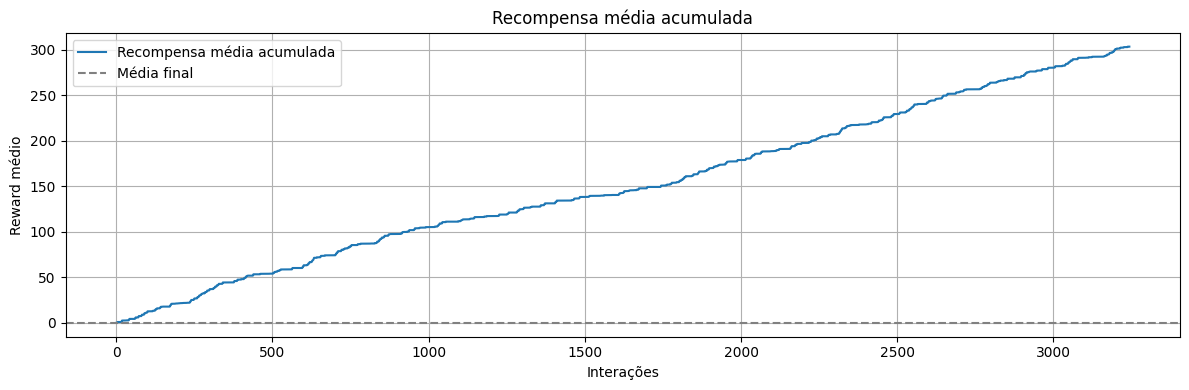

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].cumsum(), label='Recompensa média acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

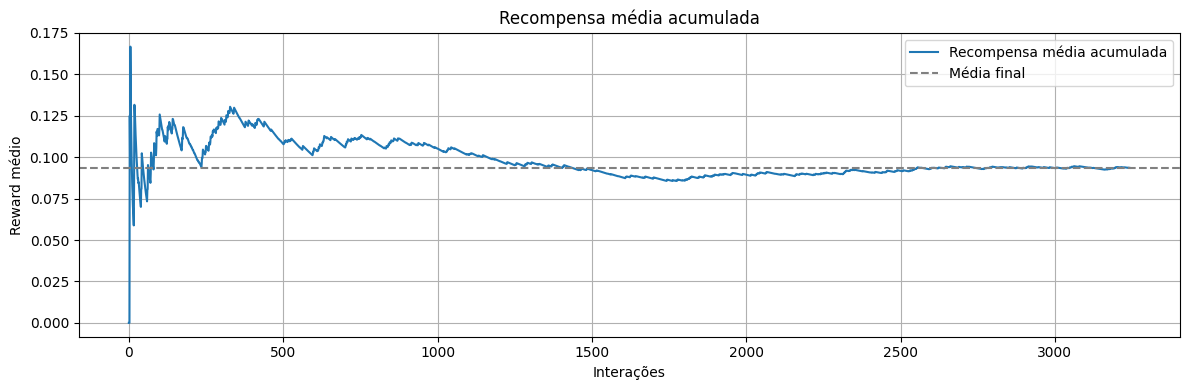

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].expanding().mean(), label='Recompensa média acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
weights = modelo_usuario.weights
weights_df = pd.DataFrame.from_dict(weights, orient='index')
weights_df

,0,1,2,3,4,5
393768,-3.244856e+13,-3.415211e+13,-3.257024e+13,-1.385148e+13,0.000000e+00,0.0
369158,-3.280163e+13,-3.452371e+13,-3.292463e+13,-1.066053e+13,-9.635478e+12,0.0
362858,-5.909535e+07,-4.358860e+06,-1.654824e+07,0.000000e+00,0.000000e+00,0.0
439963,-1.742607e+91,-3.332793e+90,-1.212545e+91,-9.020154e+90,0.000000e+00,0.0
371551,-4.861012e+15,-1.420110e+16,-3.802006e+16,-3.329794e+16,-2.413145e+16,0.0
...,...,...,...,...,...,...
410056,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
375876,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
461190,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
451703,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
